[*********************100%***********************]  10 of 10 completed
/var/folders/2d/ws36b6y52l9fm56tq6l10zm00000gn/T/ipykernel_93157/3163903326.py:269: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data = data.resample('M').last()  # 월말 종가
/var/folders/2d/ws36b6y52l9fm56tq6l10zm00000gn/T/ipykernel_93157/3163903326.py:332: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  best_year = portfolio_returns.resample("Y").apply(lambda x: (1 + x).prod() - 1).max()
/var/folders/2d/ws36b6y52l9fm56tq6l10zm00000gn/T/ipykernel_93157/3163903326.py:333: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  worst_year = portfolio_returns.resample("Y").apply(lambda x: (1 + x).prod() - 1).min()


,Metric,Value
0,Start Balance,"$10,000"
1,End Balance,"$18,231"
2,Annualized Return (CAGR),7.70%
3,Standard Deviation,11.43%
4,Best Year,22.36%
5,Worst Year,-10.34%
6,Maximum Drawdown,-18.79%
7,Sharpe Ratio,0.70
8,Sortino Ratio,0.08


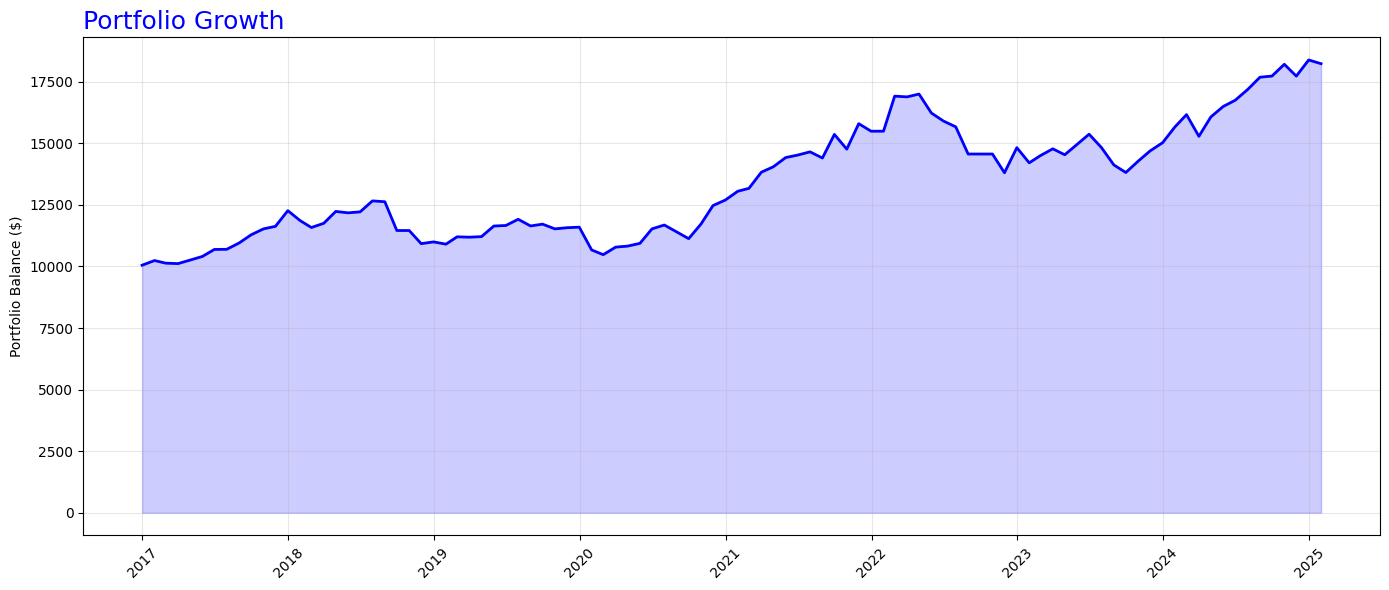

In [ ]:
# 포트폴리오 테스트
import yfinance as yf
import pandas as pd
import numpy as np

def dual_momentum_backtest(start: str, end: str):
    tickers = ["SPY", "EFA", "BIL", "AGG"]
    data = yf.download(tickers, start=start, end=end, interval="1mo", auto_adjust=True)["Close"]
    data.dropna(inplace=True)
    
    returns = data.pct_change().dropna()
    signals = []

    for i in range(12, len(data)):
        date = data.index[i]
        past_prices = data.iloc[i-12:i]
        
        # 12개월 수익률 계산
        momentum = past_prices.iloc[-1] / past_prices.iloc[0] - 1
        spy_ret = momentum["SPY"]
        bil_ret = momentum["BIL"]
        
        if spy_ret > bil_ret:
            # SPY vs EFA 중 수익률 높은 자산 선택
            best_asset = "SPY" if momentum["SPY"] > momentum["EFA"] else "EFA"
        else:
            best_asset = "AGG"
        
        signals.append(best_asset)
    
    signal_series = pd.Series(signals, index=data.index[12:])
    
    # 월별 수익률과 투자자산 결합
    portfolio_returns = []
    for i in range(len(signal_series)):
        asset = signal_series.iloc[i]
        ret = returns[asset].iloc[i]  # offset for returns matching
        portfolio_returns.append(ret)

    portfolio_returns = pd.Series(portfolio_returns, index=signal_series.index)
    
    # 누적 수익 계산
    start_balance = 10000
    cumulative = (1 + portfolio_returns).cumprod()
    end_balance = start_balance * cumulative.iloc[-1]
    
    # 성과 지표 계산
    cagr = (end_balance / start_balance) ** (1 / ((portfolio_returns.index[-1] - portfolio_returns.index[0]).days / 365)) - 1
    std_dev = portfolio_returns.std() * np.sqrt(12)
    sharpe = portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(12)
    downside_std = portfolio_returns[portfolio_returns < 0].std() * np.sqrt(12)
    sortino = portfolio_returns.mean() / downside_std * np.sqrt(12)
    drawdown = (cumulative / cumulative.cummax()) - 1
    max_drawdown = drawdown.min()
    best_year = portfolio_returns.resample("Y").apply(lambda x: (1 + x).prod() - 1).max()
    worst_year = portfolio_returns.resample("Y").apply(lambda x: (1 + x).prod() - 1).min()

    # 결과 데이터프레임
    result = pd.DataFrame({
        "Metric": [
            "Start Balance", "End Balance", "Annualized Return (CAGR)", 
            "Standard Deviation", "Best Year", "Worst Year",
            "Maximum Drawdown", "Sharpe Ratio", "Sortino Ratio"
        ],
        "Value": [
            f"${start_balance:,.0f}", f"${end_balance:,.0f}", f"{cagr:.2%}",
            f"{std_dev:.2%}", f"{best_year:.2%}", f"{worst_year:.2%}",
            f"{max_drawdown:.2%}", f"{sharpe:.2f}", f"{sortino:.2f}"
        ]
    })

    return result



import matplotlib.pyplot as plt

def plot_portfolio_growth(portfolio_returns: pd.Series, initial_balance: float = 10000):
    # 누적 수익률 계산
    cumulative = (1 + portfolio_returns).cumprod() * initial_balance

    # 플롯 생성
    plt.figure(figsize=(14, 6))
    plt.plot(cumulative.index, cumulative.values, color='blue', linewidth=2)
    plt.fill_between(cumulative.index, cumulative.values, color='blue', alpha=0.2)
    
    # 제목 및 축 라벨
    plt.title("Portfolio Growth", fontsize=18, color="blue", loc="left")
    plt.ylabel("Portfolio Balance ($)")
    plt.xlabel("")
    plt.grid(True, alpha=0.3)

    # 포맷팅
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


def relative_strength_strategy(start: str, end: str):
    tickers = ["SPY", "IWD", "IWM", "IWN", "MTUM", "EFA", "TLT",
               "IEF", "LQD", "DBC", "VNQ", "BWX", "GLD"]
    
    tickers = ["SPY",  "IWM",  "MTUM", "EFA", "TLT",
               "IEF", "LQD", "DBC", "VNQ", "GLD"]
    
    data = yf.download(tickers, start=start, end=end, interval="1mo", auto_adjust=True)["Close"]
    data.dropna(inplace=True)

    # 수익률 저장
    returns = data.pct_change().dropna()
    
    # 전략 실행
    selected_assets = []
    portfolio_returns = []

    for i in range(12, len(data)):
        date = data.index[i]
        price_window = data.iloc[i-12:i]  # 12개월 룩백
        ma_window = data.iloc[i-10:i]     # 10개월 이동평균

        momentum_scores = {}
        for ticker in tickers:
            try:
                m1 = price_window[ticker].iloc[-1] / price_window[ticker].iloc[-2] - 1
                m3 = price_window[ticker].iloc[-1] / price_window[ticker].iloc[-4] - 1
                m6 = price_window[ticker].iloc[-1] / price_window[ticker].iloc[-7] - 1
                m12 = price_window[ticker].iloc[-1] / price_window[ticker].iloc[0] - 1
                score = np.mean([m1, m3, m6, m12])
                momentum_scores[ticker] = score
            except:
                continue

        # 모멘텀 상위 3개 선택
        top_etfs = sorted(momentum_scores.items(), key=lambda x: x[1], reverse=True)[:3]
        chosen = []

        for ticker, _ in top_etfs:
            price = data[ticker].iloc[i]
            ma10 = ma_window[ticker].mean()
            if price > ma10:
                chosen.append(ticker)

        selected_assets.append(chosen)

        # 수익률 계산
        if len(chosen) == 0:
            ret = 0
        else:
            ret = returns.loc[date, chosen].mean()
        portfolio_returns.append(ret)

    # 결과 시리즈
    portfolio_returns = pd.Series(portfolio_returns, index=data.index[12:])

    # 누적 수익률
    initial_balance = 10000
    cumulative = (1 + portfolio_returns).cumprod() * initial_balance
    end_balance = cumulative.iloc[-1]

    # 성과지표
    duration_years = (portfolio_returns.index[-1] - portfolio_returns.index[0]).days / 365
    cagr = (end_balance / initial_balance) ** (1 / duration_years) - 1
    std = portfolio_returns.std() * np.sqrt(12)
    sharpe = portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(12)
    downside_std = portfolio_returns[portfolio_returns < 0].std() * np.sqrt(12)
    sortino = portfolio_returns.mean() / downside_std
    drawdown = (cumulative / cumulative.cummax()) - 1
    mdd = drawdown.min()
    best_year = portfolio_returns.resample("Y").apply(lambda x: (1 + x).prod() - 1).max()
    worst_year = portfolio_returns.resample("Y").apply(lambda x: (1 + x).prod() - 1).min()

    summary = pd.DataFrame({
        "Metric": [
            "Start Balance", "End Balance", "Annualized Return (CAGR)",
            "Standard Deviation", "Best Year", "Worst Year",
            "Maximum Drawdown", "Sharpe Ratio", "Sortino Ratio"
        ],
        "Value": [
            f"${initial_balance:,.0f}", f"${end_balance:,.0f}", f"{cagr:.2%}",
            f"{std:.2%}", f"{best_year:.2%}", f"{worst_year:.2%}",
            f"{mdd:.2%}", f"{sharpe:.2f}", f"{sortino:.2f}"
        ]
    })

    return summary, portfolio_returns


def taa_backtest_pv_style(start: str, end: str, tickers: list, initial_balance: float = 10000):
    data = yf.download(tickers, start=start, end=end, interval="1mo", auto_adjust=True)["Close"]
    data.dropna(inplace=True)
    returns = data.pct_change().dropna()

    # 전략 변수 초기화
    selected_assets = []
    portfolio_returns = []

    for i in range(12, len(data) - 1):  # 마지막 달 수익률은 없으니 -1
        date = data.index[i]
        next_date = data.index[i + 1]
        price_window = data.iloc[i - 12:i]
        ma_window = data.iloc[i - 10:i]

        # 모멘텀 계산: 평균 수익률 (1,3,6,12개월)
        scores = {}
        for t in tickers:
            try:
                m1 = price_window[t].iloc[-1] / price_window[t].iloc[-2] - 1
                m3 = price_window[t].iloc[-1] / price_window[t].iloc[-4] - 1
                m6 = price_window[t].iloc[-1] / price_window[t].iloc[-7] - 1
                m12 = price_window[t].iloc[-1] / price_window[t].iloc[0] - 1
                avg = np.mean([m1, m3, m6, m12])
                scores[t] = avg
            except:
                continue

        top3 = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:3]
        selected = []

        for t, _ in top3:
            price = data[t].iloc[i]
            ma10 = ma_window[t].mean()
            if price > ma10:
                selected.append(t)

        selected_assets.append((date, selected))

        if len(selected) == 0:
            ret = 0  # 현금 수익률
        else:
            ret = returns.loc[next_date, selected].mean()
        portfolio_returns.append(ret)

    # 수익률 시리즈
    portfolio_returns = pd.Series(portfolio_returns, index=[d for d, _ in selected_assets])
    cumulative = (1 + portfolio_returns).cumprod() * initial_balance
    end_balance = cumulative.iloc[-1]

    # 성과 지표 계산
    duration_years = (portfolio_returns.index[-1] - portfolio_returns.index[0]).days / 365
    cagr = (end_balance / initial_balance) ** (1 / duration_years) - 1
    std = portfolio_returns.std() * np.sqrt(12)
    sharpe = portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(12)
    downside_std = portfolio_returns[portfolio_returns < 0].std() * np.sqrt(12)
    sortino = portfolio_returns.mean() / downside_std
    drawdown = (cumulative / cumulative.cummax()) - 1
    mdd = drawdown.min()
    best_year = portfolio_returns.resample("Y").apply(lambda x: (1 + x).prod() - 1).max()
    worst_year = portfolio_returns.resample("Y").apply(lambda x: (1 + x).prod() - 1).min()

    summary = pd.DataFrame({
        "Metric": [
            "Start Balance", "End Balance", "Annualized Return (CAGR)",
            "Standard Deviation", "Best Year", "Worst Year",
            "Maximum Drawdown", "Sharpe Ratio", "Sortino Ratio"
        ],
        "Value": [
            f"${initial_balance:,.0f}", f"${end_balance:,.0f}", f"{cagr:.2%}",
            f"{std:.2%}", f"{best_year:.2%}", f"{worst_year:.2%}",
            f"{mdd:.2%}", f"{sharpe:.2f}", f"{sortino:.2f}"
        ]
    })

    return summary, portfolio_returns


def taa_backtest_pv_exact(start: str, end: str, tickers: list, initial_balance: float = 10000):
    # 1. 일일 데이터 받아서 월말 종가만 추출
    data = yf.download(tickers, start=start, end=end, interval='1d', auto_adjust=True)["Close"]
    data = data.resample('M').last()  # 월말 종가
    data.dropna(axis=0, how='any', inplace=True)
    
    # 2. 월별 수익률
    returns = data.pct_change().dropna()

    # 3. 백테스트 실행
    portfolio_returns = []
    signal_dates = []
    
    for i in range(12, len(data) - 1):  # 마지막 수익률은 다음 달 필요하므로 -1
        date = data.index[i]
        next_date = data.index[i + 1]
        signal_dates.append(date)

        past_prices = data.iloc[i - 12:i]  # 12개월 룩백
        ma_window = data.iloc[i - 10:i]

        # 모멘텀 계산 (1,3,6,12개월 수익률 평균)
        momentum_scores = {}
        for t in tickers:
            try:
                m1 = past_prices[t].iloc[-1] / past_prices[t].iloc[-2] - 1
                m3 = past_prices[t].iloc[-1] / past_prices[t].iloc[-4] - 1
                m6 = past_prices[t].iloc[-1] / past_prices[t].iloc[-7] - 1
                m12 = past_prices[t].iloc[-1] / past_prices[t].iloc[0] - 1
                score = np.mean([m1, m3, m6, m12])
                momentum_scores[t] = score
            except:
                continue

        # 상위 3개 선택
        top_assets = sorted(momentum_scores.items(), key=lambda x: x[1], reverse=True)[:3]

        selected = []
        for t, _ in top_assets:
            price_now = data[t].iloc[i]
            ma10 = ma_window[t].mean()
            if price_now > ma10:
                selected.append(t)

        # 수익률 계산
        if len(selected) == 0:
            ret = 0.0  # 현금 수익률 0%
        else:
            ret = returns.loc[next_date, selected].mean()

        portfolio_returns.append(ret)

    # 4. 수익률 시리즈 생성
    portfolio_returns = pd.Series(portfolio_returns, index=signal_dates)
    cumulative = (1 + portfolio_returns).cumprod() * initial_balance
    end_balance = cumulative.iloc[-1]

    # 5. 성과 지표 계산
    duration_years = (portfolio_returns.index[-1] - portfolio_returns.index[0]).days / 365
    cagr = (end_balance / initial_balance) ** (1 / duration_years) - 1
    std = portfolio_returns.std() * np.sqrt(12)
    sharpe = portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(12)
    downside_std = portfolio_returns[portfolio_returns < 0].std() * np.sqrt(12)
    sortino = portfolio_returns.mean() / downside_std
    drawdown = (cumulative / cumulative.cummax()) - 1
    mdd = drawdown.min()
    best_year = portfolio_returns.resample("Y").apply(lambda x: (1 + x).prod() - 1).max()
    worst_year = portfolio_returns.resample("Y").apply(lambda x: (1 + x).prod() - 1).min()

    summary = pd.DataFrame({
        "Metric": [
            "Start Balance", "End Balance", "Annualized Return (CAGR)",
            "Standard Deviation", "Best Year", "Worst Year",
            "Maximum Drawdown", "Sharpe Ratio", "Sortino Ratio"
        ],
        "Value": [
            f"${initial_balance:,.0f}", f"${end_balance:,.0f}", f"{cagr:.2%}",
            f"{std:.2%}", f"{best_year:.2%}", f"{worst_year:.2%}",
            f"{mdd:.2%}", f"{sharpe:.2f}", f"{sortino:.2f}"
        ]
    })

    return summary, portfolio_returns


tickers = ["SPY",  "IWM",  "MTUM", "EFA", "TLT",
               "IEF", "LQD", "DBC", "VNQ", "GLD"]

summary_df, returns_series = taa_backtest_pv_exact("2015-12-31", "2025-02-28", tickers)
display(summary_df)
plot_portfolio_growth(returns_series)


In [ ]:
# pandas 시리즈 분석하기
import pandas as pd

# s1 = pd.Series([10,20,30])
# display(s1)


# s2 = pd.Series([100,200,300],index=['a','b','c'])
# display(s2)


# data = {'J': 100, 'F':200, 'M':300}
# s3 = pd.Series(data)
# display(s3)


# data = {'A':[10],'B':[20],'C':[30]}
# df = pd.DataFrame(data)

# display(df)
# display(df['A'])


data = [
    pd.Series([0.1, 0.2, 0.3]),  # interval 1
    pd.Series([0.4, 0.5, 0.6]),  # interval 3
    pd.Series([0.7, 0.8, 0.9])   # interval 6
]

display(data)

0    10
1    20
2    30
dtype: int64

a    100
b    200
c    300
dtype: int64

J    100
F    200
M    300
dtype: int64

,A,B,C
0,10,20,30


0    10
Name: A, dtype: int64

[0    0.1
 1    0.2
 2    0.3
 dtype: float64,
 0    0.4
 1    0.5
 2    0.6
 dtype: float64,
 0    0.7
 1    0.8
 2    0.9
 dtype: float64]